## Trees and Phylogenetics
bipython also gives us lots of basic functionality for dealing with trees. this includes reading/writing/converting trees, tree visualization tools, and interfaces to external phylogenetics packages such as phylip and PAML

To start I've included a toy tree example named `tree.newick` in the notebooks directory. That file is written in the [Newick](https://en.wikipedia.org/wiki/Newick_format) format which uses a series of parentheses to describe the relations of taxa up a tree. In this case I've used the tree

`(((1,2),(3,4)),(5,6));`

We will start by reading in the tree and using the native print() to summarize it

In [7]:
from Bio import Phylo

tree = Phylo.read("data/tree.newick", "newick")
print(tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade()
            Clade()
                Clade(name='1')
                Clade(name='2')
            Clade()
                Clade(name='3')
                Clade(name='4')
        Clade()
            Clade(name='5')
            Clade(name='6')


We can also draw the tree quite easily

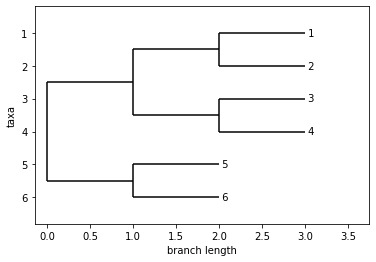

In [5]:
Phylo.draw(tree)

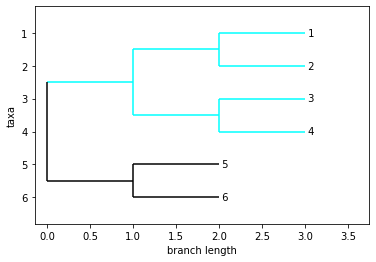

In [6]:
mrca = tree.common_ancestor({"name": "1"}, {"name": "3"})
mrca.color="cyan"
Phylo.draw(tree)

## Distance trees for our spike protein alignments


In [36]:
from Bio import AlignIO, SeqIO
import os
from Bio.Align.Applications import MafftCommandline

#open small set of seqs
small_set = list(SeqIO.parse("data/covid_small.fasta","fasta"))
#delete bad one we found
del small_set[13]

#get genes
Entrez.email = "fake_email@thanks.com"
with Entrez.efetch(db="nucleotide", rettype="gb", retmode="text", id="NC_045512.2") as handle:
    refseq = SeqIO.read(handle, "gb")
print("downloaded", refseq.id, refseq.description)
small_set.append(refseq)
SeqIO.write(small_set, "data/temp.fasta", "fasta")

#now run alignment
mafft_cline = MafftCommandline("mafft", input="data/temp.fasta")
assert os.path.isfile('/Users/adk/miniconda3/bin/mafft'), "mafft executable missing"
stdout, stderr = mafft_cline()
with open("data/covid_small_ref.aligned.fasta", "w") as handle:
    handle.write(stdout)
    
    
#gene_list = [ x  for x in refseq.features if x.type == 'CDS']
#import and look at it
new_align = AlignIO.read("data/covid_small_ref.aligned.fasta","fasta")
print(new_align)

#get spike bit and write file
spike_align = new_align[:,gene_list[2].location.start.position:gene_list[2].location.end.position]
SeqIO.write(small_set, "data/spike_align.fasta", "fasta")

downloaded NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
SingleLetterAlphabet() alignment with 25 rows and 29903 columns
--------------ccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Wuhan/WIV06/2019|EPI_ISL_402129|2019-12-30
-------------accttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Wuhan/WIV07/2019|EPI_ISL_402130|2019-12-30
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF012/2020|EPI_ISL_403932|2020-01-14
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF014/2020|EPI_ISL_403934|2020-01-15
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF025/2020|EPI_ISL_403935|2020-01-15
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF028/2020|EPI_ISL_403936|2020-01-17
-----------ataccttcccaggtaacaaaccaaccaactttc...--- hCoV-19/Guangdong/20SF040/2020|EPI

25

In [48]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Align import MultipleSeqAlignment
calculator = DistanceCalculator('identity')


dm = calculator.get_distance(spike_align)


DistanceMatrix(names=['hCoV-19/Wuhan/WIV06/2019|EPI_ISL_402129|2019-12-30', 'hCoV-19/Wuhan/WIV07/2019|EPI_ISL_402130|2019-12-30', 'hCoV-19/Guangdong/20SF012/2020|EPI_ISL_403932|2020-01-14', 'hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15', 'hCoV-19/Guangdong/20SF014/2020|EPI_ISL_403934|2020-01-15', 'hCoV-19/Guangdong/20SF025/2020|EPI_ISL_403935|2020-01-15', 'hCoV-19/Guangdong/20SF028/2020|EPI_ISL_403936|2020-01-17', 'hCoV-19/Guangdong/20SF040/2020|EPI_ISL_403937|2020-01-18', 'hCoV-19/Wuhan/IPBCAMS-WH-03/2019|EPI_ISL_403930|2019-12-30', 'hCoV-19/Wuhan/HBCDC-HB-01/2019|EPI_ISL_402132|2019-12-30', 'hCoV-19/Zhejiang/WZ-01/2020|EPI_ISL_404227|2020-01-16', 'hCoV-19/Zhejiang/WZ-02/2020|EPI_ISL_404228|2020-01-17', 'hCoV-19/USA/WA1/2020|EPI_ISL_404895|2020-01-19', 'hCoV-19/Shenzhen/HKU-SZ-005/2020|EPI_ISL_405839|2020-01-11', 'hCoV-19/Shenzhen/HKU-SZ-002/2020|EPI_ISL_406030|2020-01-10', 'hCoV-19/USA/IL1/2020|EPI_ISL_404253|2020-01-21', 'hCoV-19/USA/CA1/2020|EPI_ISL_406034|2020-01-23', 

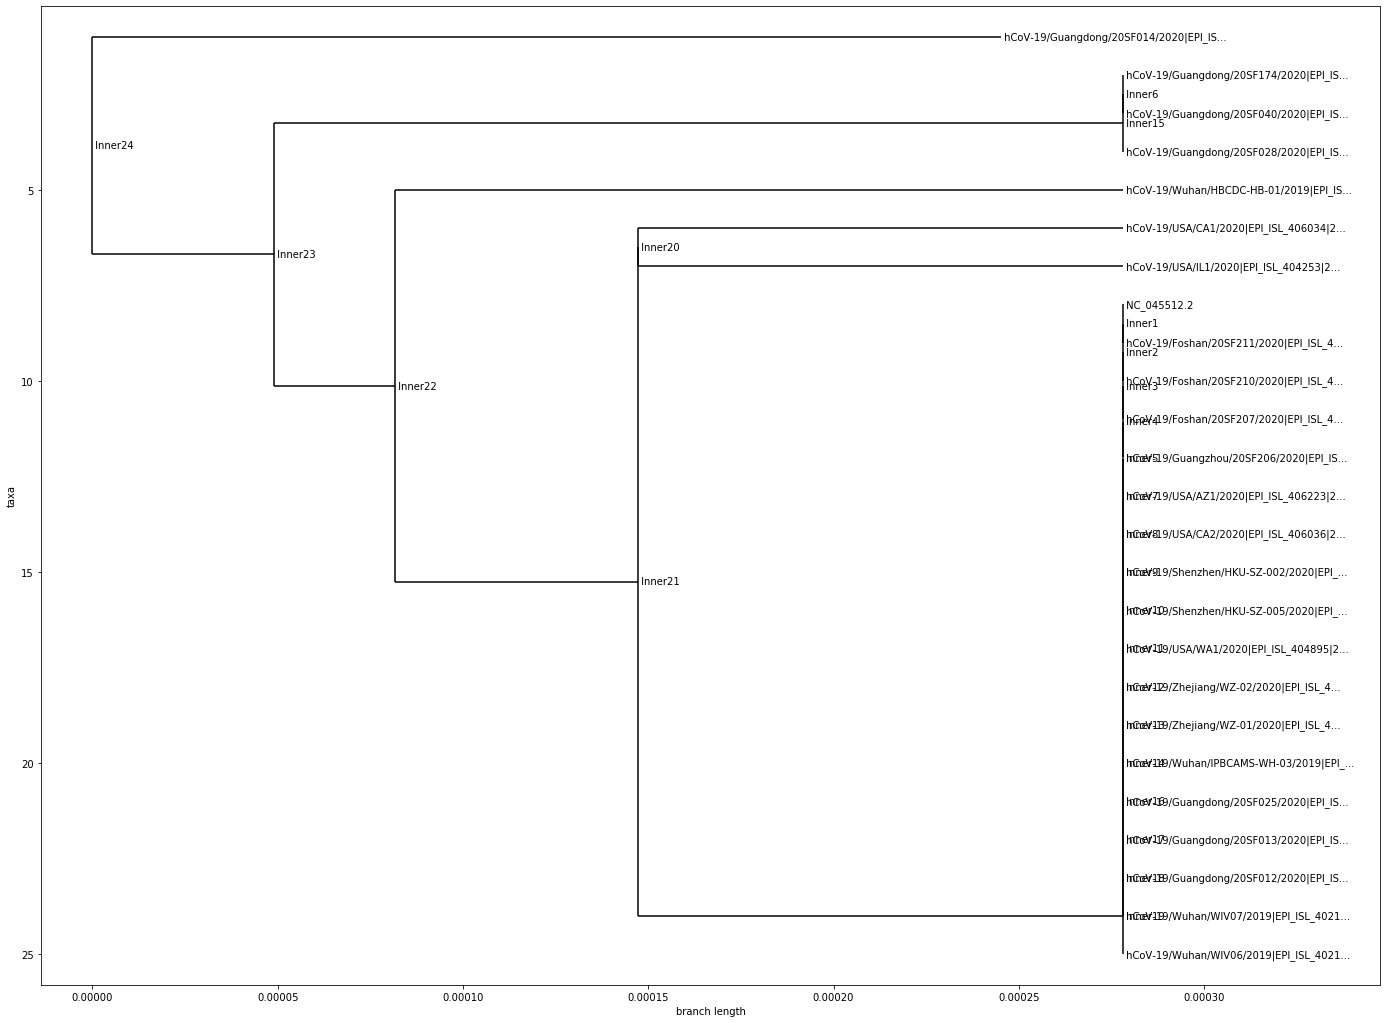

hCoV-19/Wuhan/WIV06/2019|EPI_ISL_402129|2019-12-30	0
hCoV-19/Wuhan/WIV07/2019|EPI_ISL_402130|2019-12-30	0.0	0
hCoV-19/Guangdong/20SF012/2020|EPI_ISL_403932|2020-01-14	0.0	0.0	0
hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15	0.0	0.0	0.0	0
hCoV-19/Guangdong/20SF014/2020|EPI_ISL_403934|2020-01-15	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0
hCoV-19/Guangdong/20SF025/2020|EPI_ISL_403935|2020-01-15	0.0	0.0	0.0	0.0	0.00026164311878595914	0
hCoV-19/Guangdong/20SF028/2020|EPI_ISL_403936|2020-01-17	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0.0005232862375719183	0.00026164311878595914	0
hCoV-19/Guangdong/20SF040/2020|EPI_ISL_403937|2020-01-18	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0.00026164311878595914	0.0005232862375719183	0.00026164311878595914	0.0	0
hCoV-19/Wuhan/IPBCAMS-WH-03/2019|EPI_ISL_403930|2019-12-30	0.0	0.0	0.0	0.0	0.00026164311878595914	0.0	0.000

In [77]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=[24,18])
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(spike_align)
Phylo.draw(tree,axes=ax)
fig.axes
calculator = DistanceCalculator('identity')




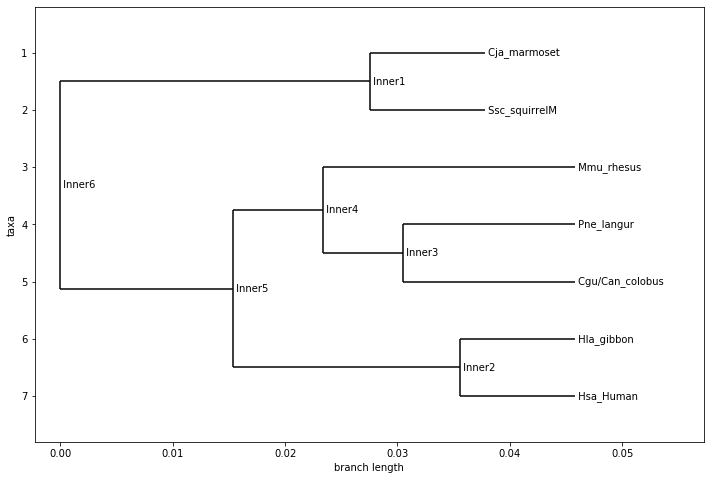

Hsa_Human	0
Hla_gibbon	0.02051282051282055	0
Cgu/Can_colobus	0.0692307692307692	0.0692307692307692	0
Pne_langur	0.06666666666666665	0.07692307692307687	0.03076923076923077	0
Mmu_rhesus	0.04871794871794877	0.05384615384615388	0.043589743589743546	0.0461538461538461	0
Ssc_squirrelM	0.07435897435897432	0.07435897435897432	0.0871794871794872	0.10256410256410253	0.06666666666666665	0
Cja_marmoset	0.07435897435897432	0.0692307692307692	0.08205128205128209	0.09743589743589742	0.06153846153846154	0.02051282051282055	0
	Hsa_Human	Hla_gibbon	Cgu/Can_colobus	Pne_langur	Mmu_rhesus	Ssc_squirrelM	Cja_marmoset


In [79]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from matplotlib import pyplot as plt

lyso = AlignIO.read("data/lysozymeSmall.fasta","fasta")
fig,ax = plt.subplots(figsize=[12,8])
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(lyso)
Phylo.draw(tree,axes=ax)
fig.axes

dm = calculator.get_distance(lyso)
print(dm)

## Using PAML for phylogenetics
For a number of you in here phylogenetics will be one of your common use points for computational biology. biopython has all these neat built ins that help you do things efficiently, without having to reinvent the wheel. 

Among these there exists a nice interface with the popular PAML software package. PAML allows us to perform maximum likelihood phylogenetic estimation in a flexible way. The reason it is so popular though is that it implements a number of tests for positive selection using comparisons of the rate of substitution between synonymous sites ($dS$) and nonsynonymous sites ($dN$). Briefly PAML can estimate the ratio of substitutions rates $\omega = dN / dS$. If all mutations had no effect on fitness than we should expect these rates to be equivalent and $\omega = 1$. If however most mutations at nonsynonymous sites were harmful and thus deleterious to the fitness of the organism, we would expect $\omega < 1$. If on the other nonsynonymous mutations were beneficial on average we could expect $\omega > 1$.

Let's use PAML quickly to play with these ideas.

In [ ]:
from Bio.Phylo.PAML import codeml
cml = codeml.Codeml(alignment = "lysozymeSmall.txt", tree = "lysozymeSmall.trees",
                    out_file = "results.out", working_dir = ".")


In [ ]:
#set some PAML options
#can set them manually
cml.set_options(noisy=9,verbose=1,runmode=0,seqtype=1)
#or with a control file
cml.read_ctl_file("lysozymeSmall.ctl")
cml.print_options()

In [ ]:
result_dict=cml.run()

In [ ]:
for k in result_dict.keys():
    print(k)
print()    
print(result_dict['model'])

In [ ]:
print(list(result_dict['NSsites'][0].keys()))
print(list(result_dict['NSsites'][0]['parameters']['omega']))


In [ ]:
result_dict